# Training

In [90]:
import os

from experiments.cubes import create_model
from omegaconf import OmegaConf
import torch
from experiments.cubes import get_dataloader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader

In [98]:
base_dir = "/mnt/raid/ni/jonasb/wscrl"
exp_name = "3node_64_with_empty_intervention"

model_path = os.path.join(base_dir, exp_name, "models", "model.pt")
cfg_path = os.path.join(base_dir, exp_name, "config.yml")

In [99]:
cfg = OmegaConf.load(cfg_path)

model = create_model(cfg)
model.load_state_dict(torch.load(model_path))
model.eval()

ILCM(
  (scm): MLPImplicitSCM(
    (solution_functions): ModuleList(
      (0-2): 3 x ConditionalAffineScalarTransform(
        (param_net): Sequential(
          (0): Linear(in_features=6, out_features=100, bias=True)
          (1): ReLU()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): ReLU()
          (4): Linear(in_features=100, out_features=2, bias=True)
        )
      )
    )
    (base_density): StandardNormal()
  )
  (intervention_prior): InterventionPrior()
  (encoder): ImageEncoder(
    (net): Sequential(
      (0): ResNetDown(
        (conv1): CoordConv2d(
          (conv): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (conv2): CoordConv2d(
          (conv): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (bn1): Identity()
        (bn2): Identity()
        (point_wise): CoordConv2d(
          (conv): Conv2d(5, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (po

In [100]:
data_dir = os.path.join(base_dir, "data")
dataset = "3node_64_png"

data_path = os.path.join(data_dir, dataset)
dataloader = get_dataloader(cfg, "train", batchsize=64)

In [101]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"

## Worst performing $x_1$ and $x_2$

In [102]:
graph_kwargs = dict(
    graph_mode=cfg.training.graph_sampling.mode,
    graph_temperature=cfg.training.graph_sampling.temperature,
    graph_samples=cfg.training.graph_sampling.samples,
)

log_probs = []

for x1, x2, z1, z2, intervention_labels, *_ in dataloader:
    # GPU
    x1, x2, z1, z2, intervention_labels = (
        x1.to(device),
        x2.to(device),
        z1.to(device),
        z2.to(device),
        intervention_labels.to(device),
    )
    log_prob, model_outputs = model(
        x1,
        x2,
        # beta=beta,
        # beta_intervention_target=beta_intervention,
        pretrain_beta=cfg.training.pretrain_beta,
        full_likelihood=cfg.training.full_likelihood,
        likelihood_reduction=cfg.training.likelihood_reduction,
        # pretrain=pretrain,
        # model_interventions=model_interventions,
        # deterministic_intervention_encoder=deterministic_intervention_encoder,
        # intervention_encoder_offset=intervention_encoder_offset,
        **graph_kwargs,
    )
    log_probs.append(log_prob.detach().cpu().numpy())


log_probs = np.concatenate(log_probs).flatten()

In [105]:
k_worst = 30
idx_worst = np.argpartition(log_probs, k_worst)[:k_worst]
idx_worst

array([ 1935,  7083,  1343, 11513,  3913,  4619,   205, 14569,  5368,
       12540,  9675, 12647,  6882, 12755,  2494, 13713, 11749,  7059,
        3745,  1118,  1868,  5393, 14643, 11134,  9503, 11170,   704,
        7512, 10492,  9834])

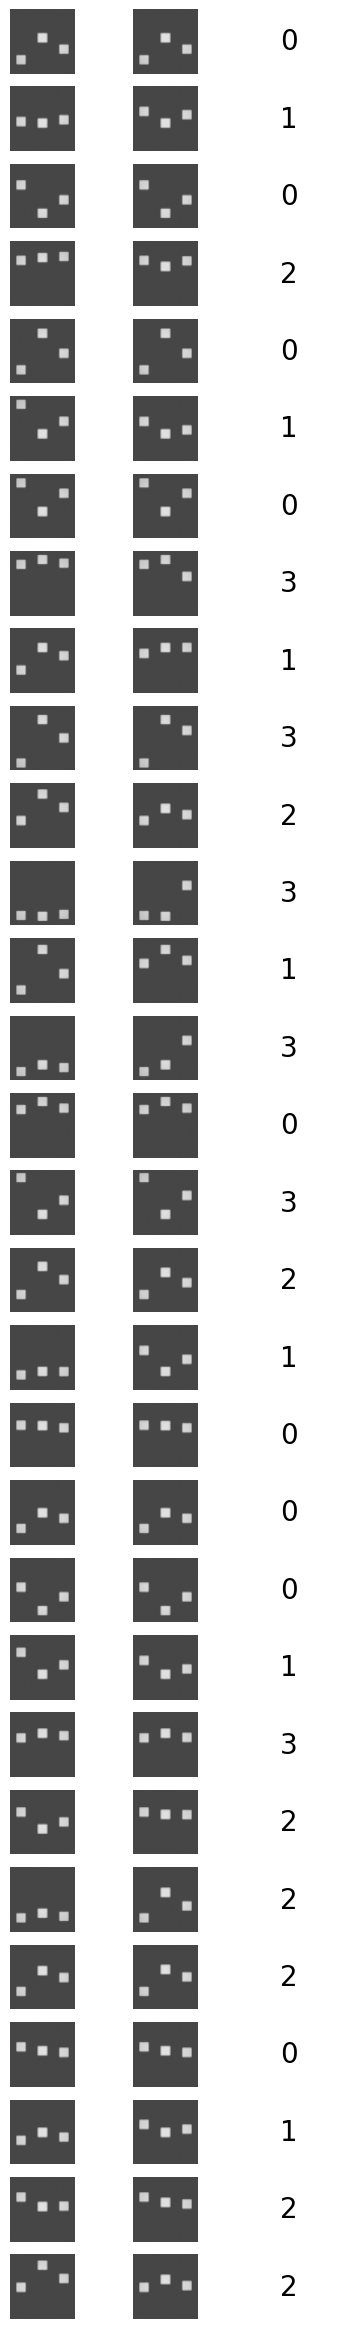

In [106]:
def plot_sample_overview(x1, x2, intervention_labels, nrows=None):
    ncols = 3

    if nrows is None:
        nrows = len(x1)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, nrows)
    )

    for ax in axes.flatten():
        ax.axis("off")

    for i in range(nrows):
        axes[i, 0].imshow(x1[i].permute(1, 2, 0))
        axes[i, 1].imshow(x2[i].permute(1, 2, 0))

        # show intervention label as text
        axes[i, 2].text(
            0.5,
            0.5,
            str(intervention_labels[i].item()),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=20,
        )


dataset_worst = Subset(dataloader.dataset, idx_worst)
dataloader_worst = DataLoader(dataset_worst, batch_size=dataset_worst.indices.size)

x1_worst, x2_worst, z1_worst, z2_worst, intervention_labels_worst, *_ = next(iter(dataloader_worst))

plot_sample_overview(x1_worst, x2_worst, intervention_labels_worst)